# **Lab4 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure


import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

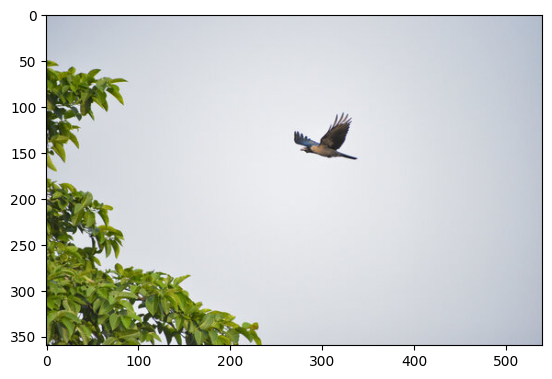

In [2]:
### START CODE HERE ###
image = plt.imread('images/bird.jpg')
plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/1.png?raw=true)
</details>

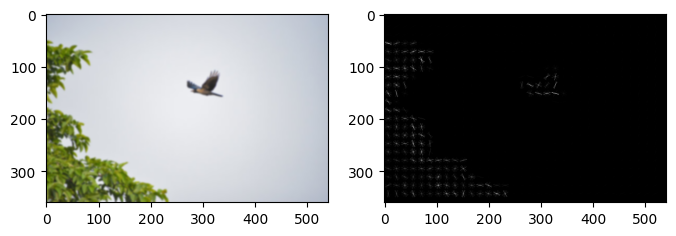

In [3]:
### START CODE HERE ###
blurry_image = cv2.GaussianBlur(image, (7, 7), 0) #ภาพ,Kernel Size, Standard Deviation
fd, hog_image = hog(blurry_image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
    )

fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs[0].imshow(blurry_image)
axs[1].imshow(hog_image, cmap='gray')
plt.show()



### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [4]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride # ระยะขยับของ convolution window
        self.h, self.w, _ = self.image.shape #ความสูงกว้างของตัวเอง
        self.hGrid = np.arange(0, self.h-tile_size+1, stride) # จุดเริ่มต้นของ sub image ทั้งหมด #ลบ tile_size ออก เพราะเราเอาแค่จุดเริ่มต้นแรก ถึงจุดเริ่มต้นท้ายสุดที่รองรับ tile
        self.wGrid = np.arange(0, self.w-tile_size+1, stride)
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    def extract_hog_features(self):
        for i in self.hGrid:
            for j in self.wGrid:
                # Extract the sub-image
                sub_image = self.image[i:(i+self.tile_size), j:(j+self.tile_size)] #เอาตำแหน่งเริ่มต้น จนถึงตำแหน่งสิ้นสุดที่มี Tile แล้ว ของภาพต้นฉบับ มาทำเป็น sub image ย่อยๆ
                features, hog_image = hog(sub_image,  # เอา Sub image ที่แบ่งไว้แล้ว มาทำ HOG ต่อ
                                          pixels_per_cell=(16, 16), 
                                          cells_per_block=(1, 1), 
                                          visualize=True, 
                                          channel_axis=-1)
                self.hog_features.append(features)
                self.hog_images.append(hog_image)

    def plot_hog_images(self):
        #แสดงผลภาพ HOG ที่เก็บเฉยๆ
        total_rows, total_cols = self.get_num_grid()
        fig, axs = plt.subplots(total_rows, total_cols)
        axs = axs.flatten()
        for i, hog_img in enumerate(self.hog_images):
            axs[i].imshow(hog_img, cmap='gray')
            axs[i].axis('off')
    
        plt.show()

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

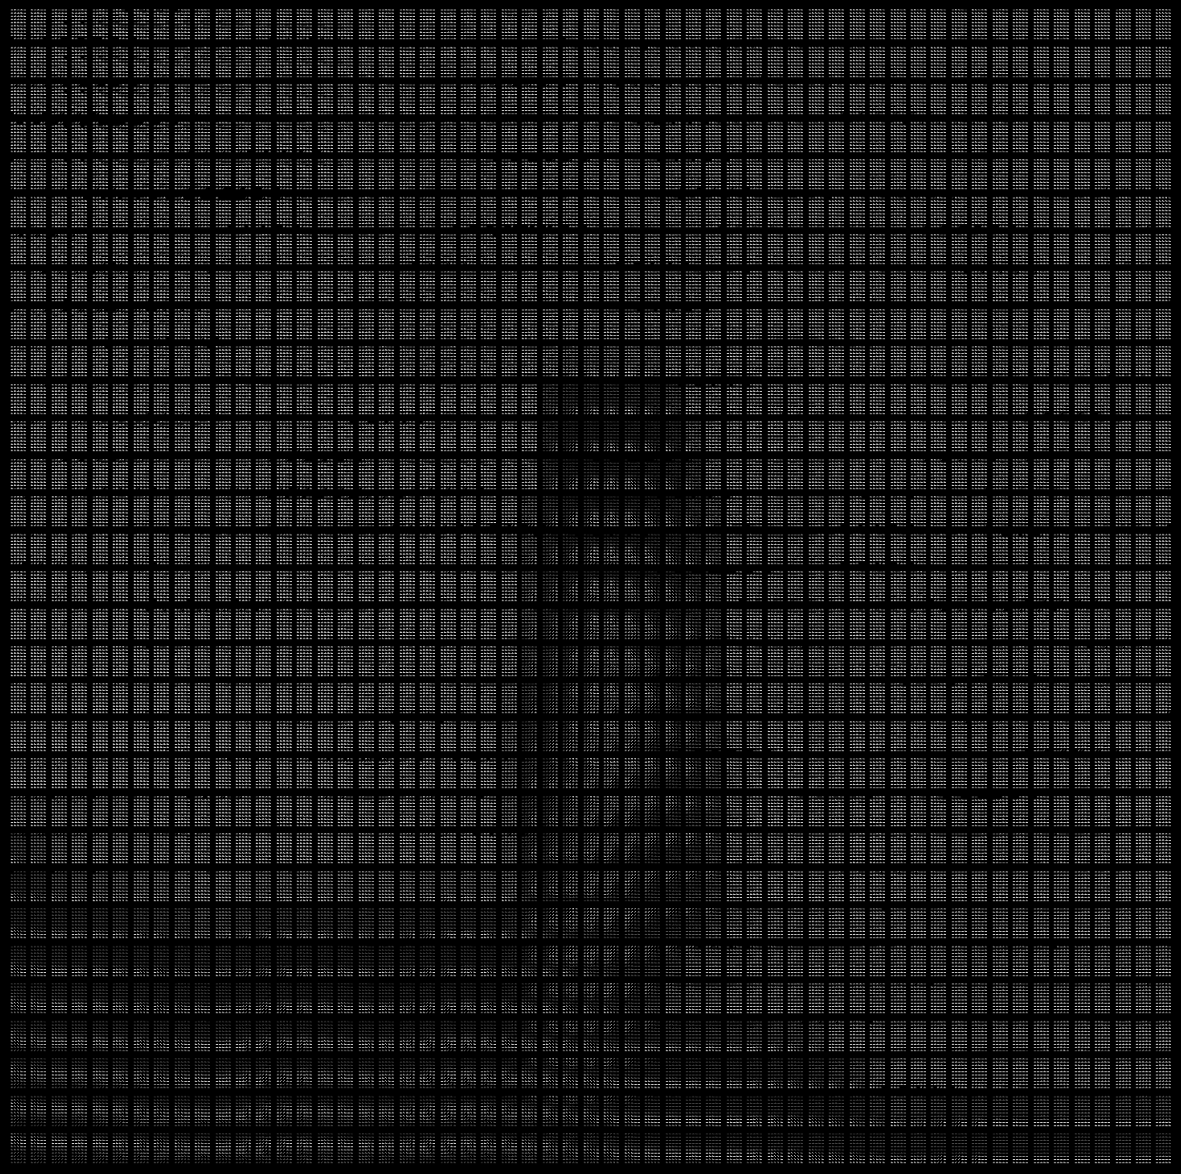
</details>

Number of grids: (13, 20)


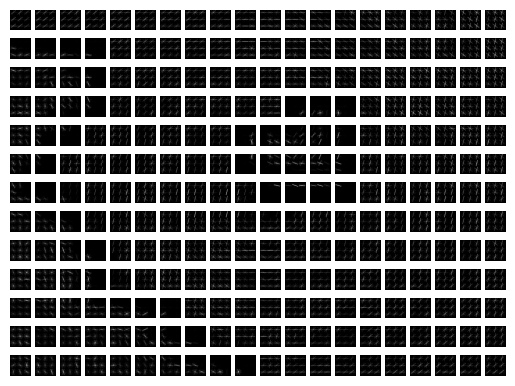

In [5]:
### START CODE HERE ###
tile_size = 50
stride = 25
#ใช้ภาพที่เบลอเพื่อลด Noise ลง
hog_extractor = HOGSubimageExtractor(blurry_image,tile_size,stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###

## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [6]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        #สร้าง array เก็บ hog_Extractor feature
        features = np.array(self.hog_extractor.hog_features)
        #Fit model จาก HOG features และ predict
        clusters = kmeans.fit_predict(features)
        #Reshape cluster ให้เป็น grid เพื่อ match กับ sub image grid
        total_rows, total_cols = self.hog_extractor.get_num_grid()
        self.cluster_array = clusters.reshape((total_rows, total_cols))
        self.all_labels = measure.label(self.cluster_array, connectivity=2)

    def plot_cluster_and_labels(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        #cluster assignments
        axs[0].imshow(self.cluster_array, cmap='viridis')
        axs[1].imshow(self.all_labels, cmap='viridis')
        cluster_plot = axs[0].imshow(self.cluster_array, cmap='viridis')
        plt.colorbar(cluster_plot, ax=axs[1])
        plt.show()

    def get_bounding_boxes(self):
        self.bounding_boxes = []
        
        # รับขนาด
        img_height, img_width = self.hog_extractor.image.shape[:2]
        grid_height, grid_width = self.cluster_array.shape
        
        #ต้อง Rescale ใหม่ เพราะการ stride ทำให้ลดขนาดภาพลงด้วย เลยต้องเอา height / grid height จะได้อัตราส่วนที่ใช้สำหรับขยาย
        scale_y = img_height / grid_height
        scale_x = img_width / grid_width
        print(scale_x)

        #ข้อมูล Coordinate เตรียมสำหรับตีกรอบ
        for region in measure.regionprops(self.all_labels):
            min_row, min_col, max_row, max_col = region.bbox
            object_id = region.label
            #Rescale coordinate ให้สัมพันธ์กับขนาดภาพต้นฉบับ
            min_row_scaled = int(min_row * scale_y)
            min_col_scaled = int(min_col * scale_x)
            max_row_scaled = int(max_row * scale_y)
            max_col_scaled = int(max_col * scale_x)

            self.bounding_boxes.append((object_id,(min_row_scaled, min_col_scaled), (max_row_scaled, max_col_scaled)))
        
        return self.bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [7]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    image_copy = image.copy()
    for bbox in bboxes:
        # object_id ไม่ได้ใช้ แต่โจทย์กำหนดว่าต้องมี
        object_id ,(min_row, min_col), (max_row, max_col) = bbox
        cv2.rectangle(image_copy, (min_col, min_row), (max_col, max_row), (0, 255, 0), 2)
        
    plt.imshow(image_copy)
### END CODE HERE ###


Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/4.png?raw=true)
</details>

c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


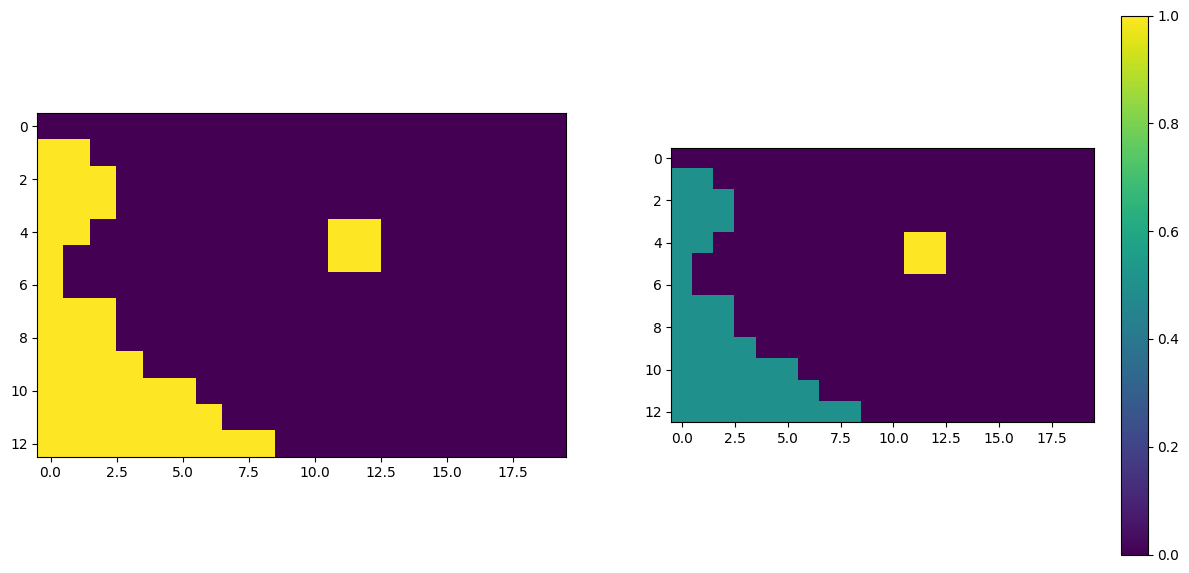

27.0


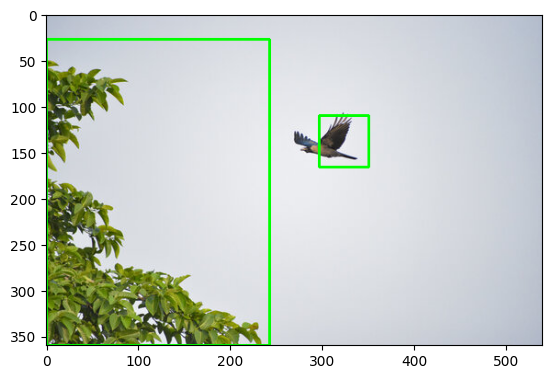

In [8]:
n_clusters = 2
random_state = 10

kmeans_cluster = KMeansCluster(hog_extractor, n_clusters, random_state)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


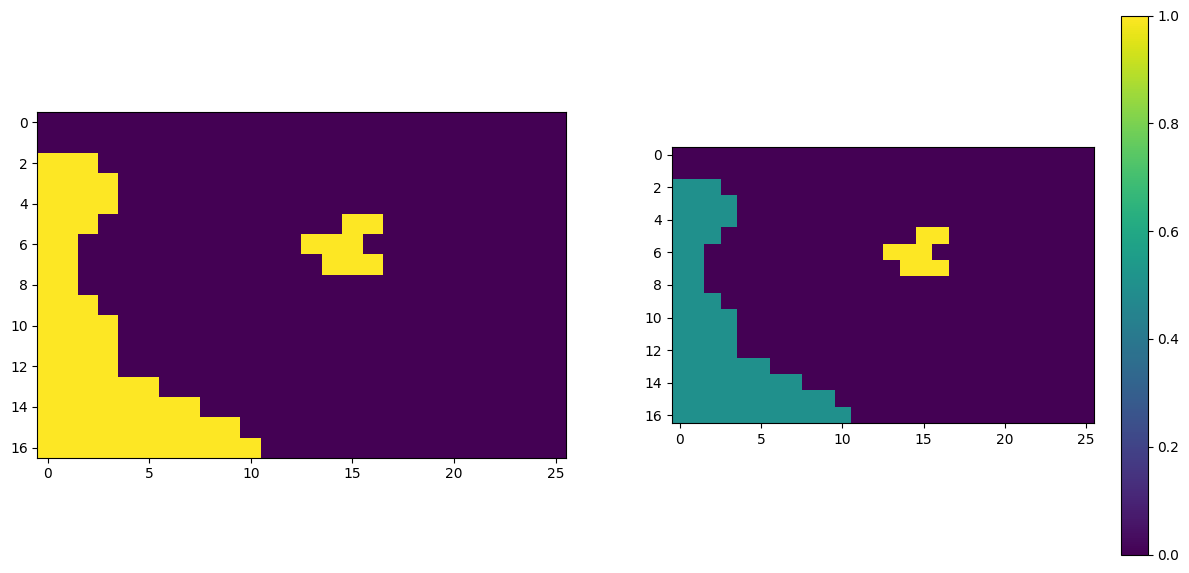

20.76923076923077


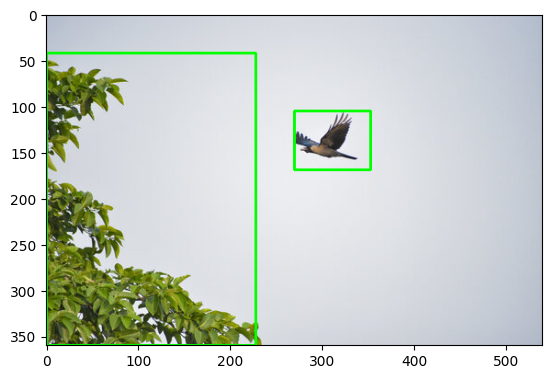

In [9]:
### START CODE HERE ###

tile_size = 40
stride = 20
hog_extractor = HOGSubimageExtractor(blurry_image,tile_size,stride)
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters, random_state)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)

### END CODE HERE ###

c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


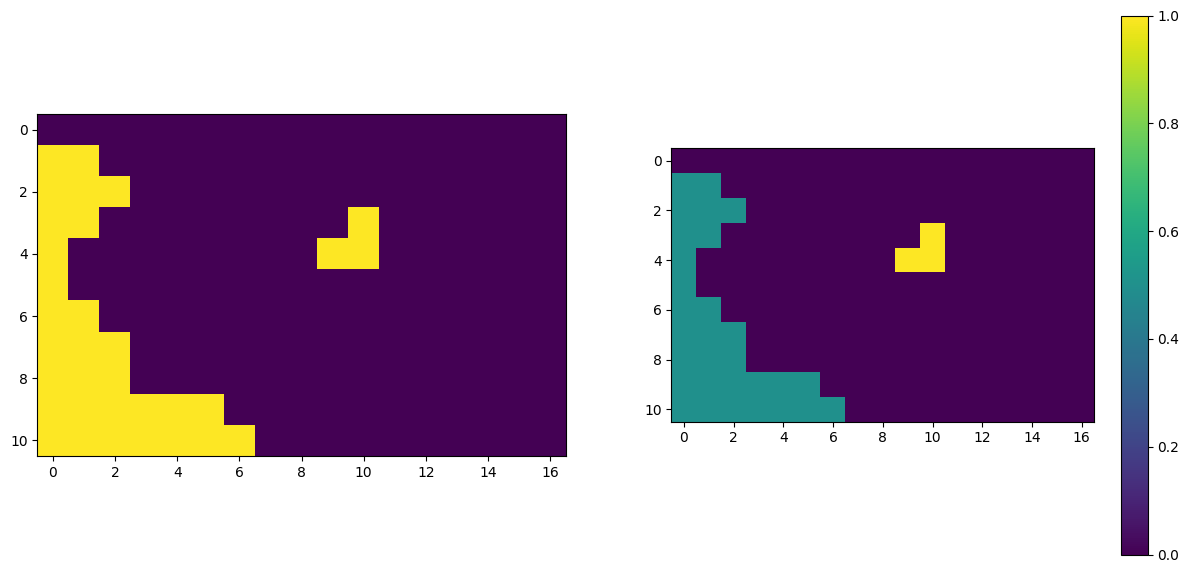

31.764705882352942


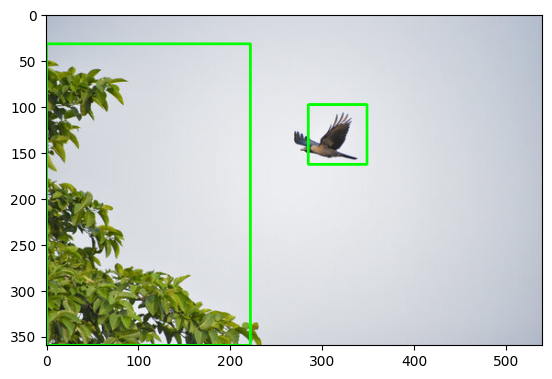

In [10]:
### START CODE HERE ###

tile_size = 60
stride = 30
hog_extractor = HOGSubimageExtractor(blurry_image,tile_size,stride)
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters, random_state)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)


### END CODE HERE ###

c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


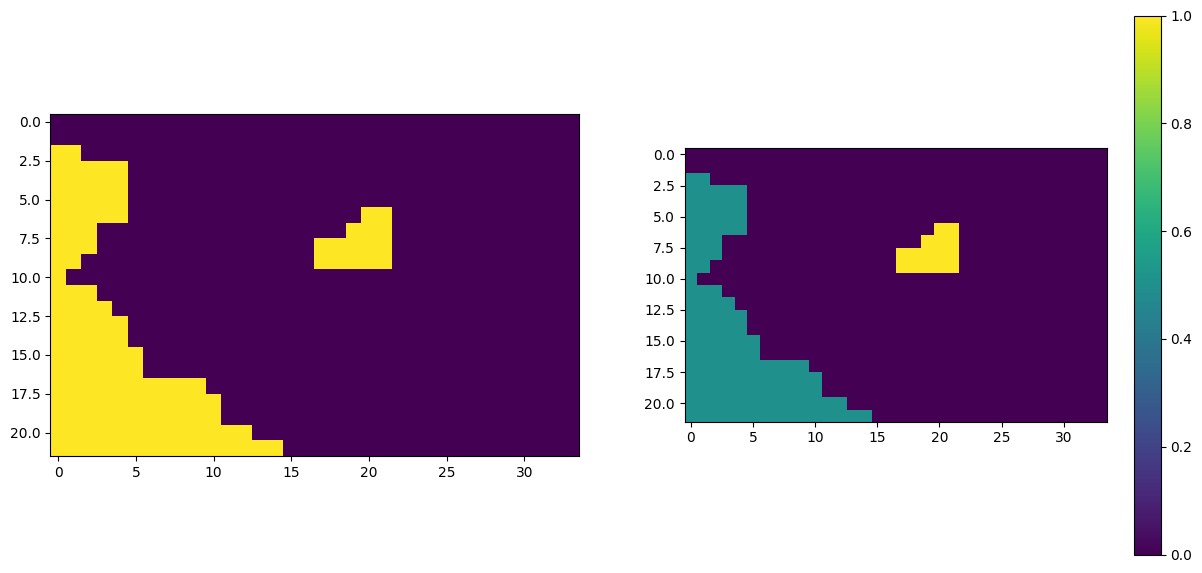

15.882352941176471


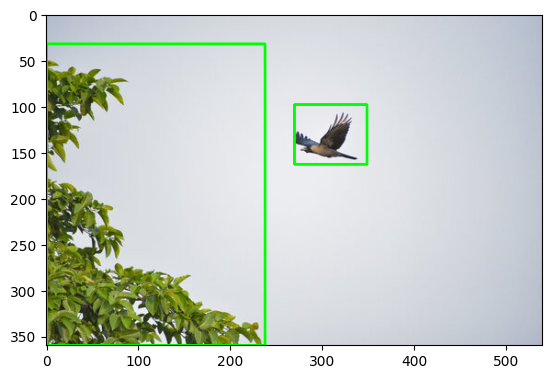

In [11]:
### START CODE HERE ###

tile_size = 40
stride = 15
hog_extractor = HOGSubimageExtractor(blurry_image,tile_size,stride)
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters, random_state)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)


### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/q5.jpg?raw=true)


<h1><font color="teal"><b>ตอบคำถามท้าย LAB 4</b></font></h1>

1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

    <font color="green"><b>ANS:</b></font> ยิ่ง Kernel ใหญ่ ยิ่ง Blur อย่างเห็นได้ชัด ซึ่งการ Blur ช่วยลด Noise ที่ไม่สำคัญต่อการ Detect ในภาพ, Standard Deviation ช่วยเพิ่ม Blur Effect แบบทีละนิดๆ ไม่เห็นชัดเท่า Kernel Size แต่ช่วยให้การจัดกลุ่มของ K-means Clustering นั้นได้ผลลัพธ์ที่อาจต่างออกไป

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

    <font color="green"><b>ANS:</b></font> Cells per block เยอะจะยิ่งจับ Feature ได้เยอะ ทำให้สามารถจับวัตุที่เล็กได้, Pixels per cell ยิ่งน้อยยิ่งจับได้ละเอียด แต่จะได้ Noise ที่เยอะตามขึ้นมา 

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

    <font color="green"><b>ANS:</b></font> ยิ่ง Tile เล็กจะยิ่งแยกประเภท Feature ได้มากขึ้น ทำให้จัดกลุ่มได้ละเอียดขึ้น, Tile ยิ่งใหญ่ จะเน้นเห็นภาพรวมมากกว่า จะไม่ได้สนใจส่วนที่แตกต่างกันน้อย

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

    <font color="green"><b>ANS:</b></font> กลุ่มที่ถูกจัดจาก K-mean อาจไม่สอดคล้องกับภาพวัตถุตามที่ต้องการ โดยเฉพาะภาพที่ซับซ้อน ไม่มีการแบ่งแยกที่ชัดเจน

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

    <font color="green"><b>ANS:</b></font> หาก K น้อยเกินไป อาจทำให้รายละเอียดเล็ก ๆ ถูกมองข้าม เช่นสีแนวๆเดียวกันจะเห็นเหมือนกัน
    หาก K มากเกินไป ทำให้จับรายละเอียดได้เยอะมาก แยกเฉดสีที่ต่างกันเพียงเล็กน้อยออกเป็นกลุ่มใหม่

    ในกรณีภาพ Blind test ทางด้านซ้าย แนะนำให้ใช้ K น้อยๆ อาจจะ k = 3 เพื่อแบ่งแยกชุดกลุ่มสี ขาว ส้ม เขียว ออกจากกัน เนื่องจากไม่ได้ต้องการรายละเอียดเฉดสีที่ต่างกันเพียงเล็กน้อย (ขึ้นอยู่กับความต้องการ)
    ในกรณีภาพขวา ใช้ K = 2 ก็เพียงพอ แยกระหว่างสีขาว กับ ดำ ออกจากกัน